## Загружаем методы для поиска аномалий из anomalies.py, методы для слгаживания из smoothing.py, метода для оценки алгоритма из metrics.py, класс для препроцесса данных из  models.py и методы для доставания отрезков сливов и заправок drain_fuel.py

In [1]:
from models import PreprocessModels
from smoothing import exponential_smoothing, double_exponential_smoothing
from anomalies import segments, detect_anomalies, upper_anomalies, lower_anomalies
from metrics import segment_accuracy
from drain_fuel import segments_drain_fuel, detect_segment

## Методы для визуализации

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set()
from dateutil.parser import parse
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

## Методы для загрузки данных

In [16]:
import os
import re
from datetime import datetime, timedelta
import numpy as np
from math import ceil, floor
import umap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

## Остальные методы

In [58]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

## Методы для тренировку и предикта данных

In [59]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from bayes_opt import BayesianOptimization

## Load data

In [93]:
root_path = ""
data_dir = os.path.join(root_path, "unpacked_2")

data_files = os.listdir(data_dir)  # target files
data_files = [x for x in data_files if x != 'readme.txt']  # remove readme


def file_to_df(file):
    """Open file and create pandas data frame"""
    full_path = os.path.join(data_dir, file)
    return pd.read_csv(full_path, sep=';')

## Get vehicle IDs

In [94]:
regex_pattern = r"vehicle(\d*)"  # ID is integer number comes right after vehicle word
compiled_pattern = re.compile(regex_pattern)
ids = compiled_pattern.findall(''.join(data_files))  # apply pattern to all file names
ids = set(ids)  # get a set of unique numbers
print(ids)

{'3', '5', '19'}


## Load info about a single vehicle

In [95]:
def open_file_id(v_id, key_lexem):
    """Key lexem determines file, for example, 'fuelLevel'"""
    regex_pattern = re.compile(f"(vehicle{v_id}_{key_lexem}" + r"_(\w|\d|_)*\.csv)")  # pattern to find appropriate name
    pattern_match = regex_pattern.search('|'.join(data_files))  # search on a whole file set
    needed_file = pattern_match.group(1)  # the file is found, now we can open it
    return file_to_df(needed_file)
    
possible_lexems = ['fuelLevel', 'ingection', 'refueling2', 'speedAndHeight', 'tachometer']

In [96]:
def load_all_files_id(v_id):
    """Generates a dictionary of all files describing a single vehicle"""
    return {lex: open_file_id(v_id, lex) for lex in possible_lexems}

# Task 2 Find cases seem like fuel stealing

## В этой задаче мы попробуем старые добрый способ: просто добавить максимальное колличество новых признаков и обучить нашу модель на них

## Загрузга и препроцесс данных

In [97]:
raw_data_base = {v_id: load_all_files_id(v_id) for v_id in ids} 

In [98]:
def change_to_correct_data(df3):
    df3['Начальный объём"'] = df3['Событие"']
    df3['Итоговый объём"'] = df3['Событие"']
    df3.drop(['Событие"','Объём изменения"'],axis=1, inplace=True)
    df3.rename(columns={'"TSID"':'TSID', 'Дата начала"':'STARTDATE',
                        'Дата окончания"':'ENDDATE','Начальный объём"':'STARTLEVEL',
                        'Итоговый объём"':'ENDLEVEL'}, inplace=True)
    df3['STARTDATE'] = df3['STARTDATE'].apply(lambda x: x[:-1])
    df3['ENDDATE'] = df3['ENDDATE'].apply(lambda x: x[:-1])
    df3['STARTLEVEL'] = df3['STARTLEVEL'].apply(lambda x: x.split('\t')[2])
    df3['ENDLEVEL'] = df3['ENDLEVEL'].apply(lambda x: x.split('\t')[3])
    return df3

In [99]:
for i in ids:
    raw_data_base[i]['refueling2'] = change_to_correct_data(pd.read_csv(f'unpacked_2\TSID_{i}_refuling2_new.csv', sep='\t"'))

In [100]:
prep_models = []
for i in ids:
    prep_models.append(PreprocessModels(raw_data_base[i]['fuelLevel'],
                                        raw_data_base[i]['ingection'],raw_data_base[i]['refueling2'],raw_data_base[i]['speedAndHeight'],
                                        raw_data_base[i]['tachometer']))
list(map(lambda x: x.preprocess_all_df(), prep_models))

[None, None, None]

In [101]:
prep_models = [prep_models[0], prep_models[2]]

In [102]:
for i in prep_models:
    
    drain, fuel = segments_drain_fuel(i.df1, i.df3.STARTDATE, i.df3.ENDDATE, i.df3['bay/drain'])
    fuel.reset_index(inplace=True)
    fuel.dropna(inplace=True)
    for j in fuel.index.values:
        i.new_df.iloc[:j].BEVALUE = i.new_df.iloc[:j].BEVALUE + (i.new_df.iloc[j].BEVALUE - i.new_df.iloc[j-1].BEVALUE)
    i.new_df.drop(fuel.DTIME,inplace=True)
    drain.drop(fuel.DTIME,inplace=True)
    drain.loc[drain.dropna().index] = pd.DataFrame(i.new_df.loc[drain.dropna().index].BEVALUE)
    i.new_df['drain'] = drain
    

## Посмотрим на наши полученные графики(убрал все заправки(добавив их к данным в каждой момент времени), чтобы можно было в дальнейшем легче работать с данными, которые зависят от времени и скорости)

In [112]:
def plotGraphics(axes, series, drain):
    
    axes.add_trace(go.Scatter(
        x=series.index,
        y=series.BEVALUE,
        mode='lines',
        name='oil'
    ))
    
    axes.add_trace(go.Scatter(
        x=pd.DataFrame(drain).index,
        y=pd.DataFrame(drain).drain,
        mode='lines',
        name='drain'
    ))

In [1]:
# for i in prep_models:
#     fig = go.Figure()
#     plotGraphics(fig, i.new_df, i.new_df.drain)
#     fig.show()

## Добавил время между разными точка и разницу в количестве бензина между ближайшими точками, также добавил измененения бензина за 1 секунду и классификацию на слив и нет слива

In [115]:
for i in prep_models:
    i.new_df['drain'] = i.new_df['drain'].fillna(0)
    i.new_df.loc[i.new_df[i.new_df['drain']!=0].index, 'drain'] = 1
    i.new_df['bevalue_diff1'] = i.new_df.BEVALUE - i.new_df.BEVALUE.shift(1)
    i.new_df['bevalue_diff1'] = i.new_df['bevalue_diff1']*10000
    i.new_df['diff_time'] =0
    i.new_df['diff_time'][1:] = np.array((i.new_df.BEVALUE.index[1:] - i.new_df.BEVALUE.index[:-1]).total_seconds() -  1e-14)
    i.new_df['speed_bevalue'] = i.new_df['bevalue_diff1']/i.new_df['diff_time']

## Давайте визуализирум данные

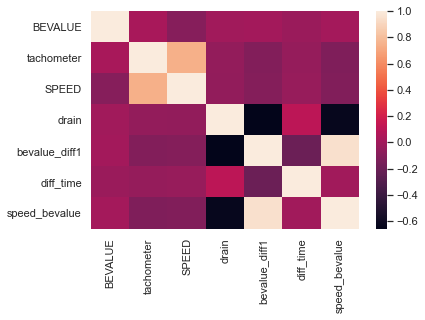

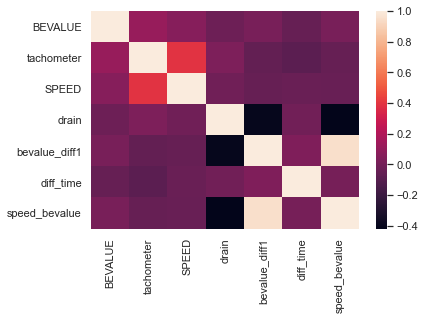

In [119]:
for i in prep_models:
    plt.figure()
    sns.heatmap(i.new_df.corr())

<Figure size 432x288 with 0 Axes>

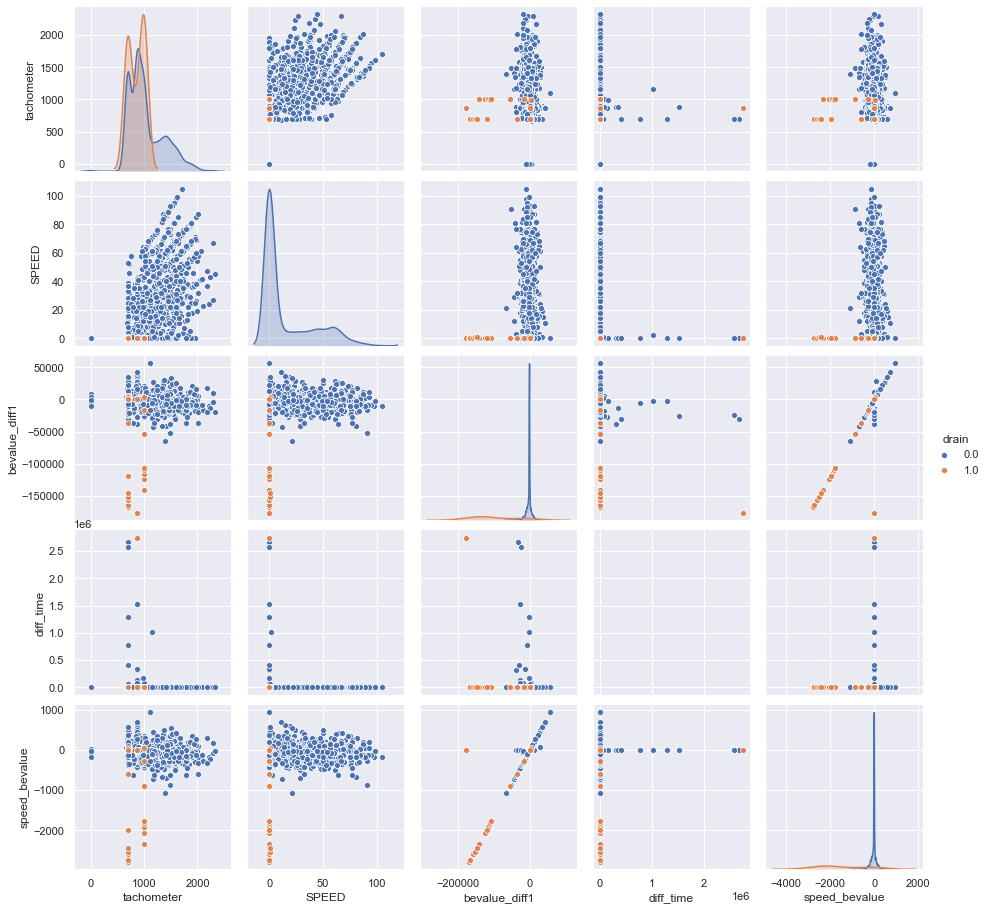

<Figure size 432x288 with 0 Axes>

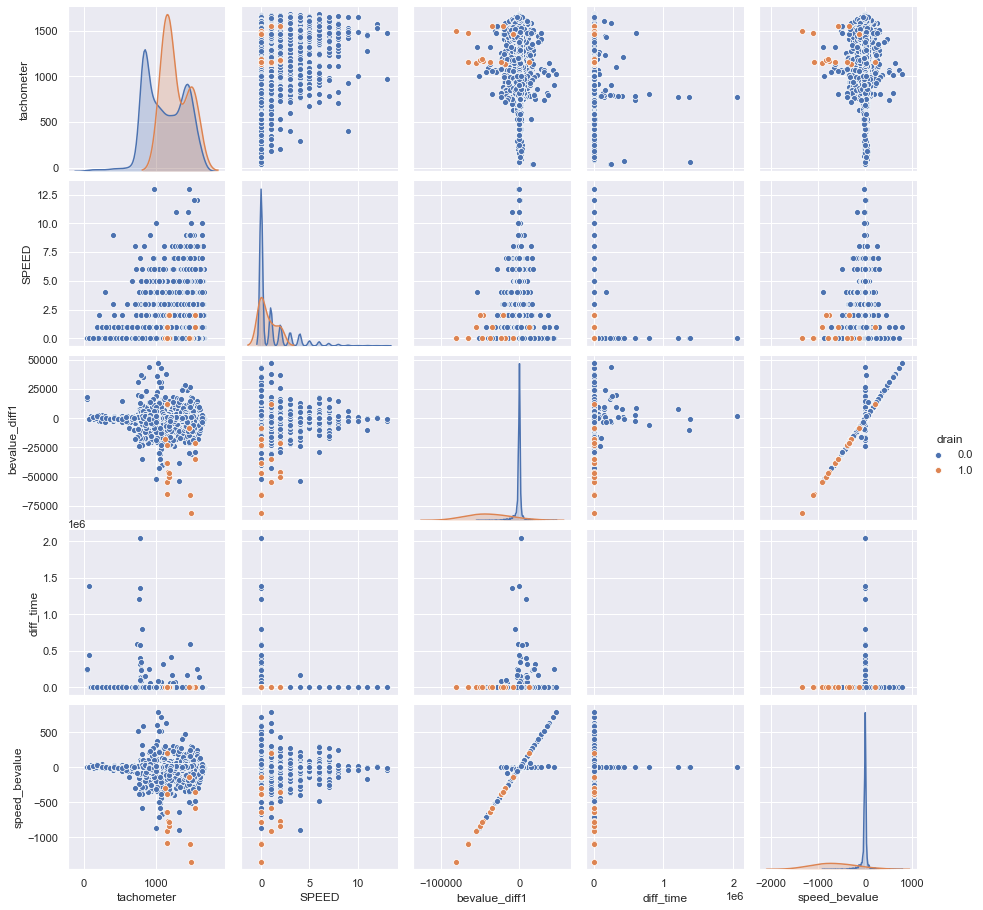

In [121]:
for i in prep_models:
    plt.figure()
    sns.pairplot(i.new_df.dropna().drop('BEVALUE',axis=1), hue="drain", diag_kind="kde")

## Как видно по pairplot, некоторые данные можно разделить линией

## Для этой задачи будем использовать xgboost, так как многие признаки обладают линенейно зависимость
## Будем тренировать с помощью байсевской оптимизации
## Будем использовать f1_score так как данных со сливами не много

In [577]:
xgb_pounds = {"max_depth": (1, 20), "learning_rate": (0, 1),
                           "booster": (0, 1), "gamma": (0, 100),
                           "min_child_weight": (0, 100), "max_delta_step": (0, 100),
                           "subsample": (0, 1), "colsample_bytree": (0, 1),
                           "colsample_bylevel": (0, 1), "colsample_bynode": (0, 1),
                           "reg_alpha": (0, 10), "reg_lambda": (0, 10),
                           "scale_pos_weight": (1, 25)
                           }

In [585]:
def xgb(max_depth, learning_rate, booster, gamma, min_child_weight, max_delta_step,
        subsample, colsample_bytree, colsample_bylevel, colsample_bynode, reg_alpha,
        reg_lambda, scale_pos_weight):
    estimator = XGBClassifier(
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        booster=['gbtree', 'dart'][int(round(booster))],
        gamma=gamma,
        min_child_weight=min_child_weight,
        max_delta_step=max_delta_step,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        colsample_bynode=colsample_bynode,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        scale_pos_weight=scale_pos_weight,
        random_state=2
    )
    return estimator

In [584]:
def xgb_cv(max_depth, learning_rate, booster, gamma, min_child_weight, max_delta_step,
           subsample, colsample_bytree, colsample_bylevel, colsample_bynode, reg_alpha, reg_lambda,
           scale_pos_weight):
    estim = xgb(max_depth, learning_rate, booster, gamma, min_child_weight, max_delta_step,
                     subsample, colsample_bytree, colsample_bylevel, colsample_bynode,
                     reg_alpha, reg_lambda, scale_pos_weight)
    cval = cross_val_score(estim, prep_mod.new_df.dropna().drop(['BEVALUE','drain'],axis=1), prep_mod.new_df.dropna().drop('BEVALUE',axis=1)['drain'],
                           scoring=make_scorer(f1_score), cv=5)

    return cval.mean()

In [586]:
optimizer_xgb = BayesianOptimization(
            f=xgb_cv,
            pbounds=xgb_pounds,
            random_state=1234,
            verbose=2
        )

In [587]:
optimizer_xgb.maximize(n_iter=500)

|   iter    |  target   |  booster  | colsam... | colsam... | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.0      |  0.1915   |  0.6221   |  0.4377   |  0.7854   |  78.0     |  0.2726   |  27.65    |  16.24    |  95.81    |  8.759    |  3.578    |  13.02    |  0.6835   |
|  2        |  0.4952   |  0.7127   |  0.3703   |  0.5612   |  0.5031   |  1.377    |  0.7728   |  88.26    |  7.933    |  61.54    |  0.7538   |  3.688    |  23.4     |  0.6514   |
|  3        |  0.0      |  0.3972   |  0.7887   |  0.3168   |  0.5681   |  86.91    |  0.4362   |  80.21    |  3.732    |  70.43    |  7.046    |  2.188    |  23.2     |  0.4421   |
|  4        |  0.0      |  0.9093   |  0.05981  |  0.1843   |  0.04736  |  67.49    |  0.5

In [592]:
model = xgb(**optimizer_xgb.max['params']).fit( prep_mod.new_df.dropna().drop(['BEVALUE','drain'],axis=1), prep_mod.new_df.dropna().drop('BEVALUE',axis=1)['drain'])

In [593]:
model

XGBClassifier(base_score=0.5, booster='dart',
              colsample_bylevel=0.38217758064146445,
              colsample_bynode=0.7088613982676611,
              colsample_bytree=0.7263682300160754, gamma=41.02761788680282,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.3115228740807512,
              max_delta_step=97.42828028820992, max_depth=11,
              min_child_weight=23.118149516819763, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=2, reg_alpha=4.8753881802865635,
              reg_lambda=5.869829995257536, scale_pos_weight=22.621213009153962,
              subsample=0.6423240772780845, tree_method='exact',
              validate_parameters=1, verbosity=None)

## Обучил лишь 1 модель, другие можно обучать также, если делать выводы по получившемося f1_score примерно 75-80 процентов, то приходим к выводу, что при очень малом количество сливов получился вполне хороший результат